In [1]:
# Import necissary packages|

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from matplotlib import cm
from pytz import timezone

In [2]:
# Specify path to videos and to all usefull files.  I have them all in one folder

vidpath = '/home/pj/UsbStick/Video/'
mypath = '/home/pj/Documents/Thesis/'

##################################################

star_catalog = pd.read_csv(mypath + 'Starz_and_vid_catalog.csv',
                           delimiter=' ', index_col= 0)

cloud_catalog = np.loadtxt(mypath + 'cloud_days.txt', dtype='str')


startendz = np.array(pd.read_csv(mypath +'start_end_observations.csv'))


star_ratios = np.loadtxt(mypath +'loc_and_ratios.txt')


analyzed_vids = pd.read_csv(mypath + 'all_videos_viewed.csv',index_col=0)


star_comparisons = pd.read_csv(mypath+ 'star_comparisons.csv', index_col=0)

######################################################



# Time Facts

In [3]:
fullnights = startendz[startendz[:,2]>(60*60)]


number_of_nights = len(fullnights)
total_observing_hours = sum(fullnights[:,2])/60/60
avg_hours_per_night = np.average(fullnights[:,2].astype(float))/60/60
min_hours_obs = np.min(fullnights[:,2].astype(float))/60/60
max_hours_obs = np.max(fullnights[:,2].astype(float))/60/60

# Star Catalog/Area Facts

In [4]:
# Find center of data
midpoint = (720/2,480/2)

# Loop of angles to rotate through
rads = np.arange(0,2*np.pi,np.deg2rad(5))

empty = []

for i in np.arange(0,len(rads)):
    # rotate original by ang radians
    ang = rads[i]
    
    # Make everything centered at (0,0)
    xs = star_ratios[:,1]-midpoint[0]
    ys = star_ratios[:,2]- midpoint[1]
    
    # Rotation matrix!
    rota = [[np.cos(ang), -np.sin(ang)],[np.sin(ang),np.cos(ang)]]
    mul = np.matmul(rota,[xs,ys])
    trans = np.transpose(mul)
    
    # Move things back to way they were
    xs2 = trans[:,0]+midpoint[0]
    ys2 = trans[:,1]+midpoint[1]
    
    # Append to array
    rotated_group = np.column_stack((star_ratios[:,0],xs2,ys2))
    if i == 0:
        all_rotated_copies = rotated_group
    else:
        all_rotated_copies = np.vstack((all_rotated_copies,rotated_group))
        
        
# Find rotated copies that fall in our field of view

condxs = (all_rotated_copies[:,1]>0)&(all_rotated_copies[:,1]<720)
condys = (all_rotated_copies[:,2]>0)&(all_rotated_copies[:,2]<480)
cond_pos = condxs&condys

rotated_copies_fit = all_rotated_copies[cond_pos]

In [26]:
dircontents = np.array(os.listdir(vidpath))

# Look at specific directory and scan it for png images
condpics = [(file[-4:] == '.png') for file in dircontents]
condvids = [(file[-4:] == '.avi') for file in dircontents]
onlypics = dircontents[condpics]
onlyvids = dircontents[condvids]



In [5]:
onlypics = np.arange(0,561)
onlyvids = np.arange(0,1077)

In [69]:
total_comparisons = len(star_comparisons)
number_ratio_points = len(star_ratios)
number_after_rot = len(rotated_copies_fit)
star_catalog_rows = len(star_catalog)
vids_with_object = len(np.unique(np.array(star_catalog['Vid_name'])))
stars_per_snapshot = star_catalog_rows/vids_with_object
number_pics = len(onlypics)
number_vids = len(onlyvids)
number_fireballs = len(analyzed_vids.loc[analyzed_vids['Real_flag']==1.0])
unique_objects = len(np.unique(np.array(star_catalog['Object'])))
dimmest_object_mag = min(star_catalog['Vmag'])
star_catalog_filenames = np.array(star_catalog['Vid_name'])
unique_starfiles = len(np.unique(star_catalog_filenames))

total_observation_area = max(cloud_catalog[:,1].astype(float))
average_observation_area = np.average(cloud_catalog[:,1].astype(float))

flux = number_fireballs / average_observation_area / total_observing_hours

# Dataframes

In [70]:
#########################################
# Time
#########################################

time_array = np.hstack((number_of_nights,total_observing_hours,
                            avg_hours_per_night,min_hours_obs,max_hours_obs))

time_facts = pd.DataFrame(time_array, index=['Total Number of Nights'
                               , 'Total Observing Hours'
                               , 'Average Hours per Night'
                               , 'Minimum Hours'
                               , 'Maximum Hours'])
time_facts.columns=['Value']


time_facts.style.set_properties(**{'background-color': 'black',
                            'color': 'white',
                            'border-color': 'white'})

,Value
Total Number of Nights,34
Total Observing Hours,291.874
Average Hours per Night,8.58453
Minimum Hours,6.99917
Maximum Hours,11


In [71]:
#########################################
# Area
#########################################

area_array = np.hstack((total_observation_area,average_observation_area))

area_facts = pd.DataFrame(area_array, index=['Total Observation Area'
                               , 'Average Observation Area'])
area_facts.columns=['Value']



area_facts.style.set_properties(**{'background-color': 'green',
                            'color': 'white',
                            'border-color': 'white'})

,Value
Total Observation Area,48363.3
Average Observation Area,46178.8


In [72]:
#########################################
# Number of Pics/Videos/Fireballs
#########################################

num_array = np.hstack((number_pics,number_vids,number_fireballs,flux))

num_facts = pd.DataFrame(num_array, index=['Number of Pics'
                               , 'Number of Vids', 'Number of Fireballs',
                                          'Flux'])
num_facts.columns=['Value']


num_facts.style.set_properties(**{'background-color': 'navy',
                            'color': 'white',
                            'border-color': 'white'})

,Value
Number of Pics,561
Number of Vids,1077
Number of Fireballs,6
Flux,4.45157e-07


In [75]:
#########################################
# Star Catalog Info
#########################################

star_array = np.hstack((star_catalog_rows,stars_per_snapshot,
                      vids_with_object,unique_objects,unique_starfiles,dimmest_object_mag,
                      total_comparisons,number_after_rot,len(onlyvids)+len(onlypics)))

star_facts = pd.DataFrame(star_array, index=['Star Catalog Rows'
                               , 'Stars Per Snapshot', 'Vids with Object',
                                          'Unique Objects','Unique Star Files','Dimmest Mag',
                                          'Number ratio data points',
                                          'Ratio data points after rotation',
                                            'Number pics&vids'])
star_facts.columns=['Value']

star_facts.style.set_properties(**{'background-color': 'gold',
                            'color': 'black',
                            'border-color': 'white'})

,Value
Star Catalog Rows,387
Stars Per Snapshot,1.43866
Vids with Object,269
Unique Objects,13
Unique Star Files,269
Dimmest Mag,-1.46
Number ratio data points,3279
Ratio data points after rotation,233546
Number pics&vids,1638


In [78]:
star_catalog.loc[star_catalog['Vmag']==-1.46]

,Vid_name,Datetime,Object,RA (deg),Dec (deg),Vmag,Alt (rad),Az (rad),xpos,ypos
0,20181119_100042_Snap.png,2018-11-19 10:00:42,Sirius,101.287155,-16.716116,-1.46,-0.196567,4.494604,155.696976,462.606049
0,20181119_090041_Snap.png,2018-11-19 09:00:41,Sirius,101.287155,-16.716116,-1.46,-0.019625,4.314712,74.960785,416.509796


In [21]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:center"'),raw=True)
    
display_side_by_side(area_facts,time_facts,num_facts,star_facts)    

,Value
Total Observation Area,48363.327836
Average Observation Area,46178.809432
,Value
Total Number of Nights,34.000000
Total Observing Hours,291.873889
Average Hours per Night,8.584526
Minimum Hours,6.999167
Maximum Hours,11.000000
,Value
Number of Pics,5.610000e+02


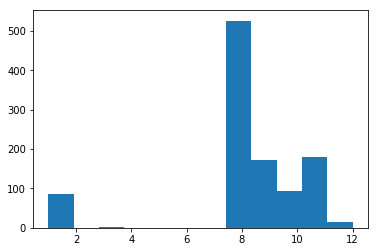

793  videos pre-November
284  videos post-November


In [68]:
list1 = [onlyvids[i][4:6] for i in np.arange(0,len(onlyvids))]
list2 = np.array(list1,dtype='float')

plt.hist(list2,12)
plt.show()

cond = (list2 == 8)|(list2 == 9)|(list2 == 10)
print(str(sum(cond))+'  videos pre-November')
print(str(sum(np.invert(cond)))+'  videos post-November')

In [22]:
analyzed_vids.loc[analyzed_vids['Real_flag']==1.0]

,Code,Filename,Real_flag
98,5MI,20181119_104615.avi,1.0
214,0JY,20181019_115534.avi,1.0
246,5MJ,20181119_124201.avi,1.0
265,5MF,20181118_102202.avi,1.0
908,0EV,20180829_094240.avi,1.0
909,0EW,20180829_110118.avi,1.0
